# MOM-SIS 0.1$^\circ$ Diagnostics

This notebook calculates and retains key diagnostics from our mom01v5 simulations. The following experiments are included:

| Experiment Name | Description |
|-----------------|-----------------|
|GFDL50 | Original simulation with 50 vertical levels. Ran from Levitus for about 60 years, but data output only saved from about year 40.|
|KDS75 | Branched from GFDL50 at year 45 (re-zeroed), but with Kial Stewart's 75 level scheme. Has now run for 103 years. Years 90-100 have 5-daily output.|
| KDS75_wind | Short (5-year) Antarctic wind perturbation case, branched from KDS75 at year 40.|
| KDS75_PI | Paul Spence's Poleward Intensification wind experiment. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade|
| KDS75_UP | Paul Spence's Increased winds case. Branched from KDS75 at year 70, will run until year 100 with 5-daily output for the last decade. (In Progress) |

**Last updated March 30 2017.**

https://github.com/OceansAus/cosima-cookbook.git

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

import dask
from dask import delayed
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import netCDF4

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

from IPython.display import display
from distributed.diagnostics import progress
import tempfile

from tqdm import tqdm_notebook
import tqdm
#import datashader

/short/v45/jm0634/conda/envs/cosima/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
DataDir = '/g/data3/hh5/tmp/cosima/mom01v5'

### Experiments

In [3]:
expts = ['GFDL50','KDS75','KDS75_UP','KDS75_PI','KDS75_wind']

In [4]:
cachedir = tempfile.gettempdir()

In [5]:
from joblib import Memory
memory = Memory(cachedir=cachedir, verbose=0)

In [6]:
from dask.distributed import Client, LocalCluster

In [7]:
client = Client()

In [8]:
import warnings 
warnings.filterwarnings("ignore", 
                        message="Unable to decode time axis into full numpy.datetime64 objects")

An experiment is a collection of outputNNN directories.  Each directory represents the output of a single job submission script. These directories are created by the *payu* tool.

An experiment is given by a fully qualified path.

The file `diag_table` identifies which fields should be in the output directory.

But we can also examine the .nc files directly to infer their contents.

for each .nc file, get variables -> dimensions

.ncfile, varname, dimensions, chunksize

Generate an index for all netCDF4 files. The results are cached, so needs only to be done once.

In [9]:
@memory.cache
def build_index(expt):
    
    ExpDir = os.path.join(DataDir, expt)
    ncfiles = glob(os.path.join(ExpDir, 'output*/*.nc'))
    ncfiles.sort()

    def get_vars(ncpath):
        
        index = []

        ds = netCDF4.Dataset(ncpath)
        ncfile = os.path.basename(ncpath)
        
        for k, v in ds.variables.items():
            index.append( (v.name, v.dimensions, 
                               tuple(v.chunking()), ncfile,
                               ncpath) )
        return index
    
    b = db.from_sequence(ncfiles)
    index = b.map(get_vars).concat()
    index = list(index)
    index = pd.DataFrame.from_records(index,
                                      columns = ['variable', 'dimensions',
                                               'chunking', 'ncfile',
                                                 'path'])
    return index


Pregenerate index files for all output directories.

In [10]:
for expt in expts:
    build_index(expt)

In [11]:
def get_nc_variable(expt, ncfile, variable, chunks={}, n=None,
                   op= lambda x: x):
    """
    For a given experiment, concatenate together variable over all time
    given a basename ncfile.
    
    By default, xarray is set to use the same chunking pattern that is
    stored in the ncfile. This can be overwritten by passing in a dictionary
    chunks or setting chunks=None for no chunking (load directly into memory).
    
    n > 0 means only use the last n ncfiles files. Useful for testing.
    
    op() is function to apply to each variable before concatenating.
    
    """
    
    df = build_index(expt)
    var = df[(df.ncfile.str.contains(ncfile)) & (df.variable == variable)]
    
    chunking = var.chunking.iloc[0]
    dimensions = var.dimensions.iloc[0]  
    default_chunks = dict(zip(dimensions, chunking))
    
    if chunks is not None:
        default_chunks.update(chunks)
        chunks = default_chunks
        
    ncfiles = sorted(list(var.path))
    
    if n is not None:
        ncfiles = ncfiles[-n:]

    b = db.from_sequence(ncfiles)
    b = b.map(lambda fn : op(xr.open_dataset(fn, chunks=chunks)[variable]) )
    datasets = b.compute()
    
    dsx = xr.concat(datasets, dim='time', coords='all')

    return dsx

## Wind Stress fields
The following code block shows the zonal- and time-averaged wind stress forcing for each experiment.

GFDL50
KDS75
KDS75_UP
KDS75_PI
KDS75_wind


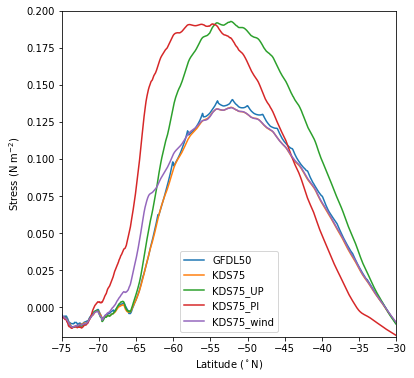

In [12]:
@memory.cache
def calc_mean_tau_x(expt):
    
    tau_x = get_nc_variable(expt, 'ocean_month.nc', 'tau_x', n=25,
                           chunks={'xu_ocean':None})

    mean_tau_x = tau_x.mean('xu_ocean').mean('time')
    mean_tau_x = mean_tau_x.compute()
    mean_tau_x.name = e
    
    return mean_tau_x

plt.figure(figsize=(6,6))

for e in expts:
    print(e)
    mean_tau_x = calc_mean_tau_x(e)
    mean_tau_x.plot()

plt.xlim([-75,-30])
plt.ylim([-0.02,0.2])
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8, fontsize=10)

# Major Transports
In this section, we catalogue and save transport diagnostics from each of the major straits.

Still to think about:
* Should we put the background functions into a separate python file and load as a module?


In [13]:
straights = [ {'name': 'DrakePassage', 'xloc':2100,'ymin':225,'ymax':650},
              {'name': 'Lombok', 'yloc':1158,'xmin':354,'xmax':361},
              {'name': 'Ombai', 'xloc':449,'ymin':1152,'ymax':1163},
              {'name': 'Timor', 'xloc':440,'ymin':1125,'ymax':1145},
              {'name': 'Bering', 'yloc':2125,'xmin':1080,'xmax':1130},
              {'name': 'Denmark', 'yloc':2125,'xmin':2380,'xmax':2580},
            ]

In [14]:
@memory.cache
def calc_transport(expt, straight):
    ## Function to calculate barotropic transport across a given line of latitude or longitude.
    ## Primarily designed for flow through straits.
    
    print('Calculating {}:{} transport'.format(expt, straight['name']))
    
    if 'xloc' in straight:

        ymin, ymax = straight['ymin'], straight['ymax']
        xloc = straight['xloc']
        
        op = lambda p: p.isel(xu_ocean=xloc)\
                        .isel(yt_ocean=slice(ymin, ymax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('yt_ocean')
                     
        transport = get_nc_variable(expt, 'ocean.nc', 'tx_trans',
                                    chunks=None,
                                    op=op)

    elif 'yloc' in straight:

        xmin, xmax = straight['xmin'], straight['xmax']
        yloc = straight['yloc']
        
        op = lambda p: p.isel(yu_ocean=yloc)\
                        .isel(xt_ocean=slice(xmin, xmax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('xt_ocean')
                
        transport = get_nc_variable(expt, 'ocean.nc', 'ty_trans',
                                    chunks=None,
                                    op=op)
    else:
        print('Transports must be along lines of either constant latitude or longitude')
        return None
    
    transport = transport.load()
       
    return transport

When distributing a computing with dask, you should try and minimize the number of task while
keeping each task appropriate to a single work regarding memory usage.

Calculating GFDL50:DrakePassage transport
Calculating GFDL50:Lombok transport
Calculating GFDL50:Ombai transport
Calculating GFDL50:Timor transport
Calculating GFDL50:Bering transport
Calculating GFDL50:Denmark transport
Calculating KDS75:DrakePassage transport
Calculating KDS75:Lombok transport
Calculating KDS75:Ombai transport
Calculating KDS75:Timor transport
Calculating KDS75:Bering transport
Calculating KDS75:Denmark transport
Calculating KDS75_UP:DrakePassage transport
Calculating KDS75_UP:Lombok transport
Calculating KDS75_UP:Ombai transport
Calculating KDS75_UP:Timor transport
Calculating KDS75_UP:Bering transport
Calculating KDS75_UP:Denmark transport
Calculating KDS75_PI:DrakePassage transport
Calculating KDS75_PI:Lombok transport
Calculating KDS75_PI:Ombai transport
Calculating KDS75_PI:Timor transport
Calculating KDS75_PI:Bering transport
Calculating KDS75_PI:Denmark transport
Calculating KDS75_wind:DrakePassage transport
Calculating KDS75_wind:Lombok transport
Calculating 

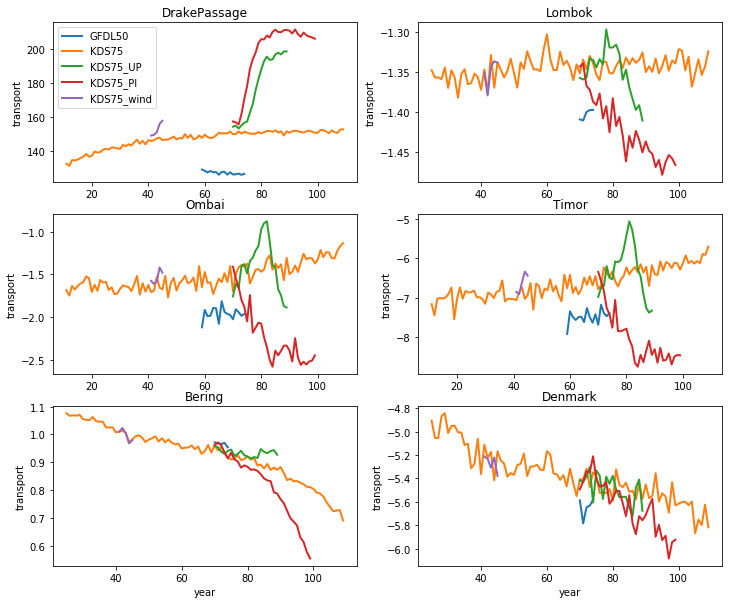

In [15]:
plt.figure(figsize=(12,10))

for expt in expts:
    nplot = 0
    
    for straight in straights:
        nplot += 1
       
        transport = calc_transport(expt, straight)
        
        # see https://github.com/spencerahill/aospy/issues/98#issuecomment-256043833
        da = transport.to_dataset(name='transport')
                                
        periods = []
        for date in da['time']:
            raw_date = date.values.item()
            periods.append(pd.Period(year=raw_date.year, month=raw_date.month, day=raw_date.day, freq='D'))
        da['time'] = pd.PeriodIndex(periods)
        da = da.groupby('time.year').mean('time')
        transport = da.transport
        
        plt.subplot(3, 2, nplot)
        transport.plot(label=expt, linewidth=2)
        plt.title( straight['name'])
        
plt.subplot(321)
plt.legend(loc='upper left')
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(322)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(323)
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(324)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(325)
#plt.ylabel('Transport (Sv)')
#plt.xlabel('Time')
plt.subplot(326)
#plt.ylabel('')
#plt.xlabel('Time')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

In [16]:
def extract_data(f):
    dataset = netCDF4.Dataset(f)
    
    data = {}
    for v in dataset.variables.values():
        if 'time' in v.dimensions and 'scalar_axis' in v.dimensions:
            data[v.name] = v[:].flatten()
    index = pd.to_datetime(dataset['time'][:], unit='D')
    df = pd.DataFrame(index=index, data=data)
    return df

@memory.cache
def calc_scalar_quantities(expt):
    print(expt)
    
    df = build_index(expt)
    
    # identify all scalar variables
    df = df[(df.ncfile == 'ocean_scalar.nc') & (df.dimensions == ('time', 'scalar_axis' )) ]
    ncfiles = sorted(list(df.path))
    
    b = db.from_sequence(ncfiles)
    b = list(b.map(extract_data))
    df = pd.concat(b)
    
    return df

scalar_quantities = {}
for expt in expts:

    scalar_quantities[expt] = calc_scalar_quantities(expt)

GFDL50
KDS75
KDS75_UP
KDS75_PI
KDS75_wind


In [17]:
scalar_quantities['GFDL50'].describe().T

,count,mean,std,min,25%,50%,75%,max
eta_global,7752.0,-1.599564e-02,6.487899e-03,-2.556028e-02,-2.260215e-02,-1.545898e-02,-9.247627e-03,-7.672984e-03
ke_tot,7752.0,3.193131e+03,4.023099e+01,3.071416e+03,3.167506e+03,3.194453e+03,3.220488e+03,3.280610e+03
pe_tot,7752.0,3.016668e+10,2.543327e+06,3.016908e+10,3.016915e+10,3.016919e+10,3.016932e+10,3.016941e+10
rhoave,7752.0,1.056026e+03,5.522925e-02,1.056079e+03,1.056080e+03,1.056081e+03,1.056081e+03,1.056082e+03
salt_global_ave,7752.0,3.471856e+01,1.059593e-03,3.471744e+01,3.471748e+01,3.471750e+01,3.471752e+01,3.471758e+01
salt_surface_ave,7752.0,3.452981e+01,1.724344e-02,3.449669e+01,3.451737e+01,3.453279e+01,3.454316e+01,3.455881e+01
temp_global_ave,7752.0,3.583095e+00,4.217766e-03,3.574442e+00,3.579929e+00,3.583148e+00,3.586063e+00,3.592330e+00
temp_surface_ave,7752.0,1.812762e+01,1.748978e-01,1.783244e+01,1.803352e+01,1.811293e+01,1.826968e+01,1.842636e+01
total_net_sfc_heating,7752.0,1.011371e-01,4.098340e+00,-7.338331e+00,-2.964327e+00,2.030339e+00,3.477559e+00,4.635539e+00
total_ocean_calving,7752.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


CPU times: user 2.37 s, sys: 34.9 ms, total: 2.4 s
Wall time: 2.57 s


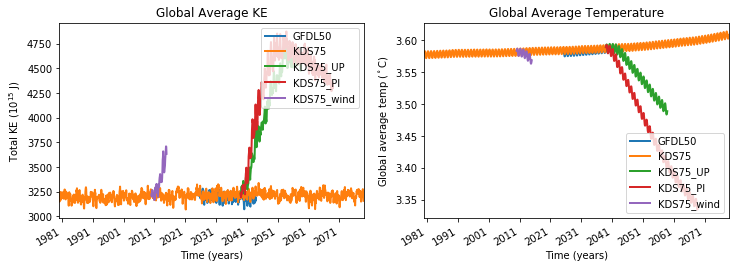

In [18]:
plt.figure(figsize=(12,4))

for expt in expts:
    
    plt.subplot(121)
    scalar_quantities[expt].ke_tot.plot(label=expt, linewidth=2)

    plt.subplot(122)
    scalar_quantities[expt].temp_global_ave.plot(label=expt, linewidth=2)

plt.subplot(121)
plt.legend(loc='upper right')
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc='lower right')
plt.ylabel('Global average temp ($^\circ$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')


## Zonal Mean Temperature

In [70]:
@memory.cache
def calc_zonal_mean_temp(expt):
    print('Calculating {} zonal_mean_temp'.format(expt))
    
    if expt == 'KDS75':
        ncfile = 'ocean_month.nc'
    else:
        ncfile = 'ocean.nc'
        
    zonal_temp = get_nc_variable(expt, ncfile, 'temp',
                                 chunks={'st_ocean': None},
                                 n=25)
    
    zonal_mean_temp = zonal_temp.mean('xt_ocean').mean('time')
    zonal_mean_temp.load()
    
    return zonal_mean_temp

In [71]:
def plot_zonal_mean_temp(expt):
    zonal_mean_temp = calc_zonal_mean_temp(expt)
    
    zonal_mean_temp.plot()
    plt.gca().invert_yaxis()
    plt.title('{}: Zonal Mean Temp'.format(expt))

CPU times: user 718 ms, sys: 66.3 ms, total: 785 ms
Wall time: 772 ms


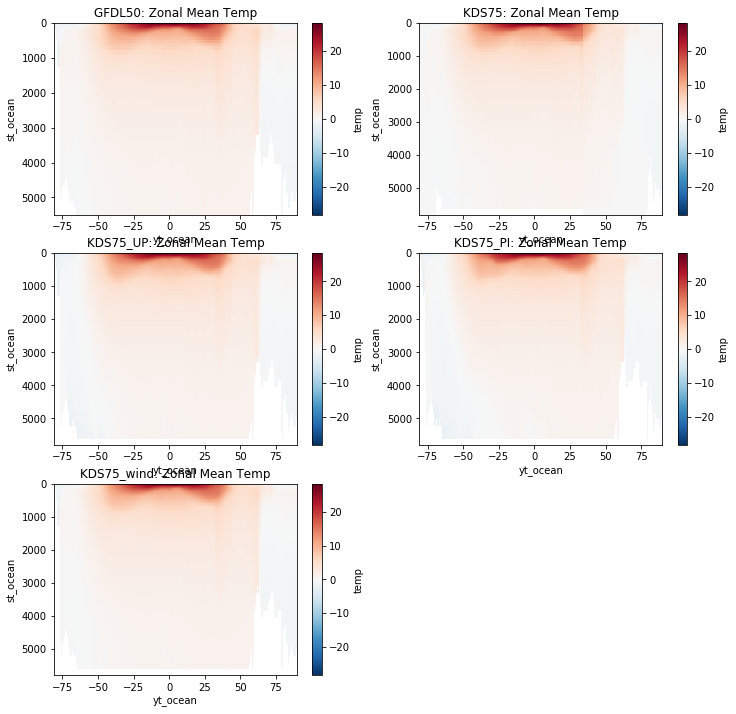

In [73]:
plt.figure(figsize=(12,12)) 
nplot = 0
for expt in expts: 

    nplot += 1
    plt.subplot(3,2,nplot)
    
    plot_zonal_mean_temp(expt)

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [19]:
@memory.cache
def calc_psi_avg(expt):
    print('Calculating {} psi_avg'.format(expt))
    
    op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                        op=op,
                        chunks={'potrho': None}, n=25)

    psi_avg = psi.mean('time')
    psi_avg = psi_avg.compute()
    
    return psi_avg

In [26]:
def plot_psi(psi_avg, expt, clev=np.arange(-20,20,2)):

    plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

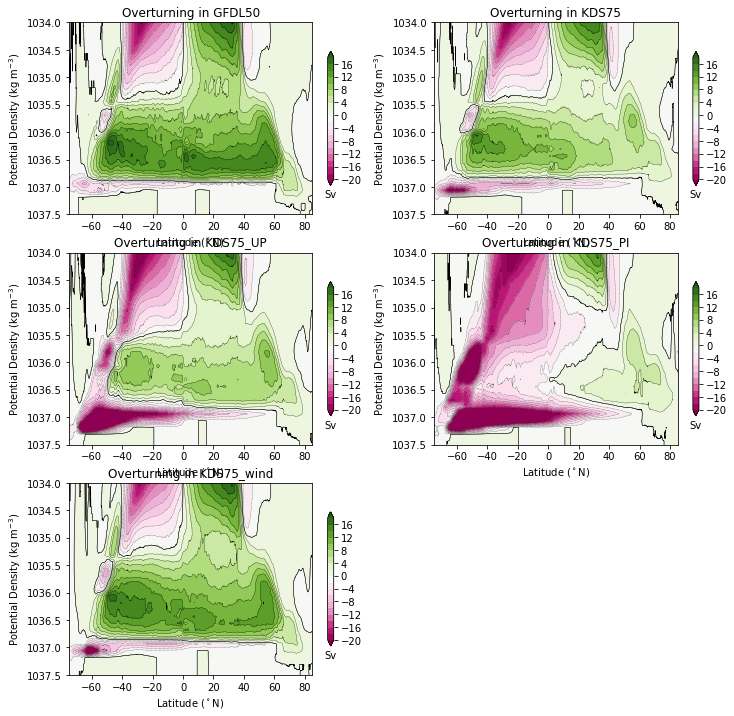

In [27]:
plt.figure(figsize=(12,12)) 
nplot = 0
for expt in expts: 

    psi_avg = calc_psi_avg(expt)
    nplot += 1

    plt.subplot(3,2,nplot)
    plot_psi(psi_avg, expt)

# Eddy Kinetic Energy
Plan here is to add:
* maps of vertically summed EKE (actually, not sure this is even feasible for this dataset)
* timeseries of globally averaged EKE

We can only do this for portions of simulations which have 5-day average velocities saved, which means directories with `ocean__*.nc` files.

In [28]:
@memory.cache
def calc_eke(expt, box_index):
    yi, xi = box_index
   
    box = {'yu_ocean': slice(300*yi, 300*(yi+1)),
           'xu_ocean': slice(400*xi, 400*(xi+1))}
    
    op = lambda p: p.isel(**box)

    u = get_nc_variable(expt, 'ocean__', 'u', op=op, n=72)
    v = get_nc_variable(expt, 'ocean__', 'v', op=op, n=72)
    
    u_avg = u.mean('time')
    v_avg = v.mean('time')

    MKE = 0.5 * (u_avg**2 + v_avg**2)
    MKE = MKE.sum(dim='st_ocean')
    MKE = MKE.to_dataset(name='MKE')
    
    u_ = u - u_avg
    v_ = v - v_avg
    
    EKE = 0.5 * (u_**2 + v_**2)

    EKE = EKE.sum(dim='st_ocean')
    EKE = EKE.to_dataset(name='EKE')

    dsx = xr.merge([MKE, EKE])
    dsx.load()
        
    return dsx

expt = 'KDS75'
calc_eke(expt, (0,0))

<xarray.Dataset>
Dimensions:   (time: 72, xu_ocean: 400, yu_ocean: 300)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 -279.4 ...
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 -80.88 ...
  * time      (time) object   99-01-03 12:00:00   99-01-08 12:00:00 ...
    geolon_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
    geolat_c  (time, yu_ocean, xu_ocean) float64 nan nan nan nan nan nan nan ...
Data variables:
    MKE       (yu_ocean, xu_ocean) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    EKE       (time, yu_ocean, xu_ocean) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [29]:
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range(2700//(300)) 
xi = range(3600//(400))

box_indexes = list(product(*[yi, xi]))

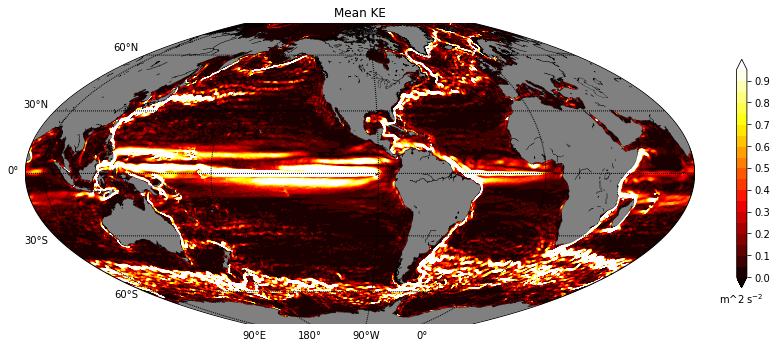

In [30]:
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

for box_index in tqdm_notebook(box_indexes):
    #print(box_index)
    dsx = calc_eke(expt, box_index)
    
    x=dsx.xu_ocean[:]
    y=dsx.yu_ocean[:]
    lon, lat = np.meshgrid(x, y)
    
    X, Y = map(lon,lat) 
    
    map.contourf(X, Y, dsx.MKE,
                 cmap=plt.cm.hot,
                 levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean KE')

[########################################] | 100% Completed |  0.2s
1035.5625
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  1.5s
1035.5625
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  0.3s
1035.5625
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
1035.5625
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.1s
1035.5625
[########################################] | 100% Completed |  0.1

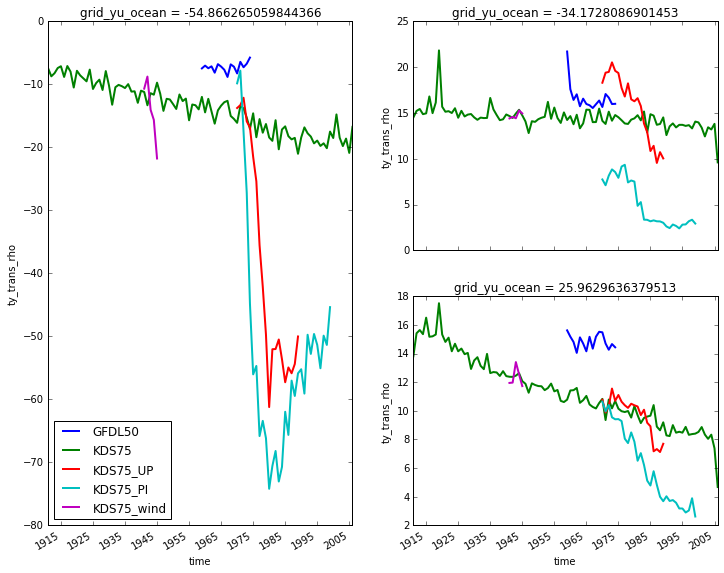

In [23]:
# for testing plotting, etc.
plt.figure(figsize=(12,10))
for expt in expts:
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/overturning.nc'))
    FileList.sort()

    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    dsx.time.attrs["units"] = 'days since 1900-01-01'
    dsx = xr.decode_cf(dsx, decode_times=True)
    
    plt.subplot(121)
    dsx.ty_trans_rho[:,60:,585].min('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    ## still need to check sensitivity to the exaction location in the line above
    print(dsx.potrho[60].values)
    
    #Southern branch of the AMOC at 35S
    plt.subplot(222)
    dsx.ty_trans_rho[:,60:,880].max('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    
    # AMOC at 26N
    plt.subplot(224)
    dsx.ty_trans_rho[:,60:,1513].max('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 

#plt.title('AABW cell at 60S')
plt.subplot(121)
plt.legend(loc='lower left')

# Indo Throughflow and other Straits
* THis is pretty much done now, but I'm retaining these files to document how we calculate transport for each strait.

<xarray.DataArray 'ty_trans' ()>
array(-1.473966432557063)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 -8.568


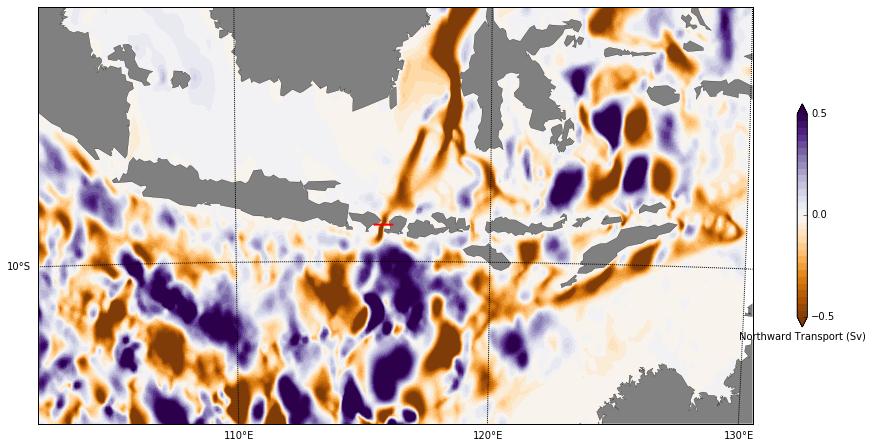

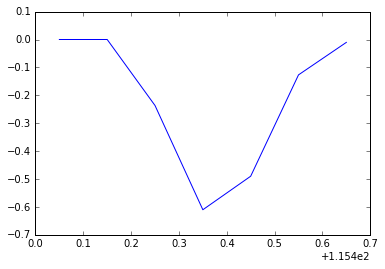

In [51]:
## test code to play with computation of lombok transport

# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,:1500,:500]
x = dsx.xt_ocean[:500]
y = dsx.yu_ocean[:1500]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-16,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
LombokDict = {'yloc':1158,'xmin':354,'xmax':361}
xx = np.array([X[LombokDict['yloc'],LombokDict['xmin']], X[LombokDict['yloc'],LombokDict['xmax']]])+360
yy = np.array([Y[LombokDict['yloc'],LombokDict['xmin']],Y[LombokDict['yloc'],LombokDict['xmax']]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')


plt.figure()
plt.plot(x[354:361]+360,transport[LombokDict['yloc'],LombokDict['xmin']:LombokDict['xmax']])
lombok_transport = np.sum(transport[LombokDict['yloc'],LombokDict['xmin']:LombokDict['xmax']])

print(lombok_transport)

<xarray.DataArray 'tx_trans' ()>
array(-1.2015297539478524)
Coordinates:
    time      float64 3.609e+04
    xu_ocean  float64 -235.0
<xarray.DataArray 'tx_trans' ()>
array(-4.769188458296412)
Coordinates:
    time      float64 3.609e+04
    xu_ocean  float64 -235.9


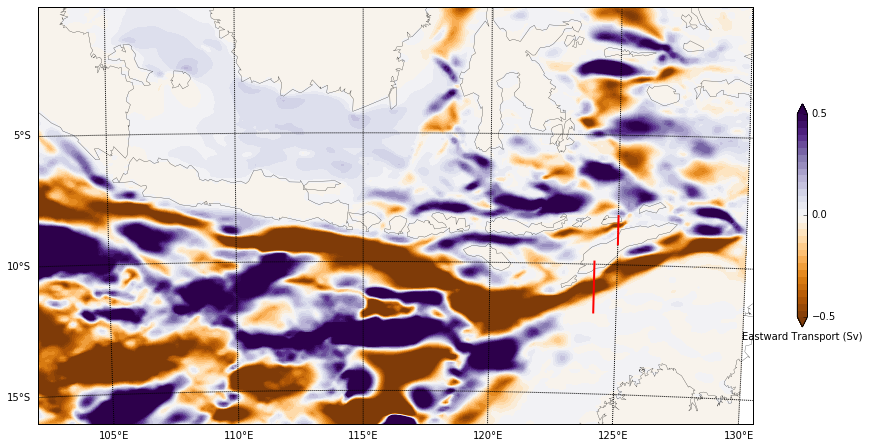

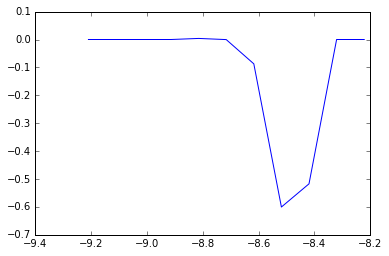

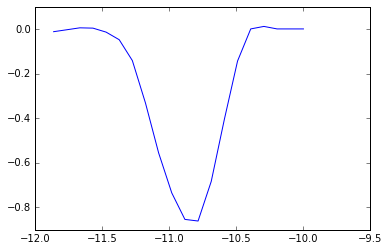

In [26]:
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output385/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
tx_trans = dsx.tx_trans[0,:,:1500,:500]
x = dsx.xu_ocean[:500]
y = dsx.yt_ocean[:1500]
transport = tx_trans.sum(axis=0)
xv, yv = np.meshgrid(x, y)

plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-258,llcrnrlat=-16,urcrnrlon=-230,urcrnrlat=0,projection='stere',resolution='l',lon_0=-245,lat_0=-7)
map.drawcoastlines(linewidth=0.25)
#map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Eastward Transport (Sv)')


# pick exact location and sum for each strait
# This for Ombai
OmbaiDict = {'xloc':449,'ymin':1152,'ymax':1163}
xx = np.array([X[OmbaiDict['ymin'],OmbaiDict['xloc']], X[OmbaiDict['ymax'],OmbaiDict['xloc']]])+360
yy = np.array([Y[OmbaiDict['ymin'],OmbaiDict['xloc']],Y[OmbaiDict['ymax'],OmbaiDict['xloc']]])
map.plot(xx,yy,linewidth=2,color='r')

# This for Timor
TimorDict = {'xloc':440,'ymin':1125,'ymax':1145}
xx = np.array([X[TimorDict['ymin'],TimorDict['xloc']], X[TimorDict['ymax'],TimorDict['xloc']]])+360
yy = np.array([Y[TimorDict['ymin'],TimorDict['xloc']],Y[TimorDict['ymax'],TimorDict['xloc']]])
map.plot(xx,yy,linewidth=2,color='r')

# plot and measure ombai
plt.figure()
plt.plot(y[OmbaiDict['ymin']:OmbaiDict['ymax']],transport[OmbaiDict['ymin']:OmbaiDict['ymax'],OmbaiDict['xloc']])
ombai_transport = np.sum(transport[OmbaiDict['ymin']:OmbaiDict['ymax'],OmbaiDict['xloc']])
print(ombai_transport)

# plot and measure timor
plt.figure()
plt.plot(y[TimorDict['ymin']:TimorDict['ymax']],transport[TimorDict['ymin']:TimorDict['ymax'],TimorDict['xloc']])
timor_transport = np.sum(transport[TimorDict['ymin']:TimorDict['ymax'],TimorDict['xloc']])
print(timor_transport)


<xarray.DataArray 'ty_trans' ()>
array(1.0250125366146676)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 65.75


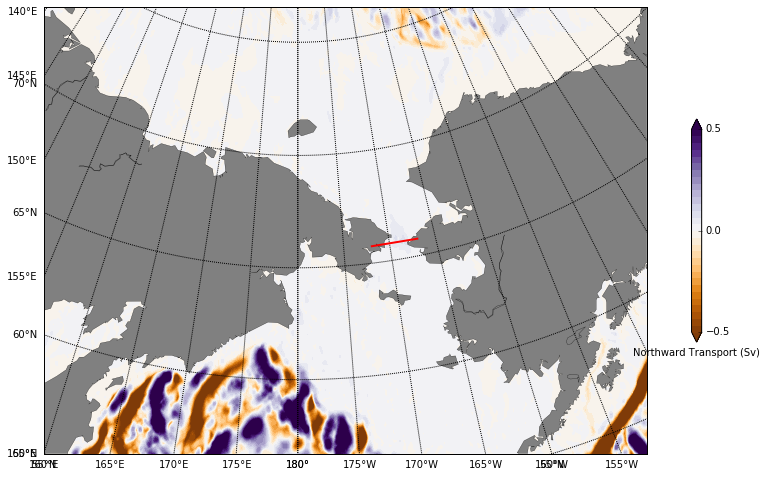

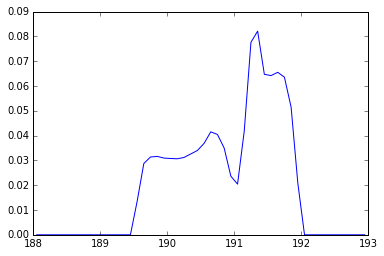

In [59]:
# Bering Strait
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,:,:1500]
x = dsx.xt_ocean[:1500]
y = dsx.yu_ocean[:]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Lombok, etc.
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-200,llcrnrlat=55,urcrnrlon=-130,urcrnrlat=70,projection='stere',resolution='l',lon_0=-180,lat_0=60)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
BeringDict = {'yloc':2125,'xmin':1080,'xmax':1130}
xx = np.array([X[BeringDict['yloc'],BeringDict['xmin']], X[BeringDict['yloc'],BeringDict['xmax']]])+360
yy = np.array([Y[BeringDict['yloc'],BeringDict['xmin']],Y[BeringDict['yloc'],BeringDict['xmax']]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

plt.figure()
plt.plot(x[BeringDict['xmin']:BeringDict['xmax']]+360,transport[BeringDict['yloc'],BeringDict['xmin']:BeringDict['xmax']])
bering_transport = np.sum(transport[BeringDict['yloc'],BeringDict['xmin']:BeringDict['xmax']])

print(bering_transport)

<xarray.DataArray 'ty_trans' ()>
array(-4.258176312495108)
Coordinates:
    time      float64 3.591e+04
    yu_ocean  float64 65.75


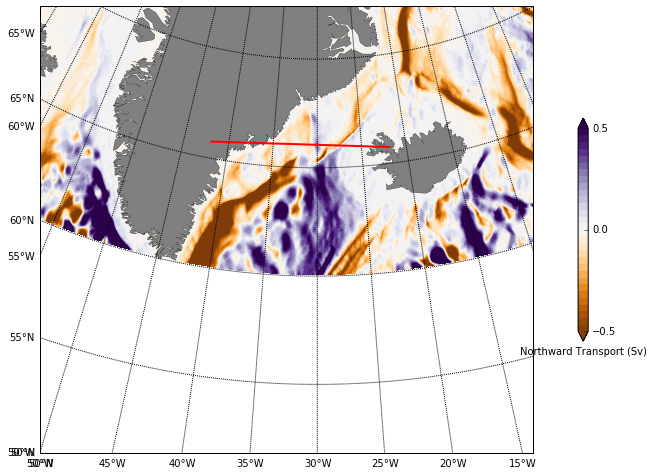

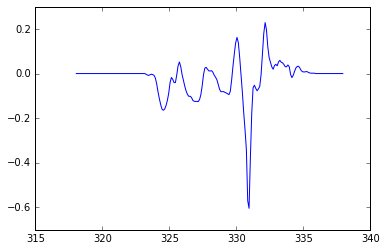

In [15]:
# Denmark Strait
# load ty_trans from ocean.nc
OceanFile = os.path.join(DataDir,expts[1],'output383/ocean.nc')
dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
ty_trans = dsx.ty_trans[0,:,2000:,2000:3000]
x = dsx.xt_ocean[2000:3000]
y = dsx.yu_ocean[2000:]

# vertically integrate
transport = ty_trans.sum(axis=0)

# plot local regions around Iceland
plt.figure(figsize=(16,8))
levels = np.linspace(-0.5,0.5,31)
map = Basemap(llcrnrlon=-50,llcrnrlat=50,urcrnrlon=0,urcrnrlat=70,projection='stere',resolution='l',lon_0=-30,lat_0=60)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,5.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,5.),labels=[True,False,False,True])
xv, yv = np.meshgrid(x, y)
X, Y = map(xv,yv) 
map.contourf(X,Y,transport, cmap=plt.cm.PuOr, levels=levels, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.5,ticks=[-1, -0.5, 0, 0.5, 1 ])
cb.ax.set_xlabel('Northward Transport (Sv)')

# pick exact location and sum for each strait
DenmarkDict = {'yloc':2125,'xmin':2380,'xmax':2580}
xx = np.array([X[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000], X[DenmarkDict['yloc']-2000,DenmarkDict['xmax']-2000]])+360
yy = np.array([Y[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000],Y[DenmarkDict['yloc']-2000,DenmarkDict['xmax']-2000]])
#print(xx)
#print(yy)

map.plot(xx,yy,linewidth=2,color='r')

plt.figure()
plt.plot(x[DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000]+360,transport[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000])
denmark_transport = np.sum(transport[DenmarkDict['yloc']-2000,DenmarkDict['xmin']-2000:DenmarkDict['xmax']-2000])

print(denmark_transport)